In [2]:
!pip install grad-cam

In [3]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Encode label
        label = self.label_encoder.transform([label])[0]

        return image, label

In [5]:
def load_images_from_folders(folder_paths):
    image_paths = []
    labels = []
    for idx, folder in enumerate(folder_paths):
        for root, _, files in os.walk(folder):
            for file in files:

                image_paths.append(os.path.join(root, file))
                label = folder.split("/")[2]
                labels.append(label)
    return image_paths, labels

In [6]:
folder_paths = [
                "TumorDataset/Training/glioma",
                "TumorDataset/Training/meningioma",
                "TumorDataset/Training/notumor",
                "TumorDataset/Training/pituitary"
               ]

image_paths, labels = load_images_from_folders(folder_paths)

In [7]:
set(labels)

{'glioma', 'meningioma', 'notumor', 'pituitary'}

# DenseNet 169

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import os



image_paths, labels = load_images_from_folders(folder_paths)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


base_model = models.densenet169(weights="DenseNet169_Weights.IMAGENET1K_V1")

# Freeze all layers except the last 10 for fine-tuning
for param in list(base_model.parameters())[:-10]:
    param.requires_grad = False


num_ftrs = base_model.classifier.in_features
base_model.classifier = nn.Sequential(
    nn.BatchNorm1d(num_ftrs, momentum=0.99, eps=0.001),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(p=0.45),
    nn.Linear(256, len(folder_paths)),
    nn.Softmax(dim=1)
)


class CustomDenseNet(nn.Module):
    def __init__(self, base_model):
        super(CustomDenseNet, self).__init__()
        self.base_model = base_model
        self.layer4 = base_model.features.denseblock4

    def forward(self, x):
        x = self.base_model(x)
        return x

model = CustomDenseNet(base_model)
model = model.to(device)


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



dataset = CustomDataset(image_paths, labels, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)




# Finetuning DenseNet169

In [9]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_predictions / total_predictions
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = loss_func(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_images.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()
            val_total_predictions += val_labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct_predictions / val_total_predictions
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}')

Epoch [1/10], Loss: 0.9213, Accuracy: 0.8525
Validation Loss: 0.8370, Validation Accuracy: 0.9081
Epoch [2/10], Loss: 0.8354, Accuracy: 0.9129
Validation Loss: 0.8111, Validation Accuracy: 0.9326
Epoch [3/10], Loss: 0.8127, Accuracy: 0.9359
Validation Loss: 0.8011, Validation Accuracy: 0.9458
Epoch [4/10], Loss: 0.8010, Accuracy: 0.9457
Validation Loss: 0.8027, Validation Accuracy: 0.9396
Epoch [5/10], Loss: 0.7910, Accuracy: 0.9547
Validation Loss: 0.7971, Validation Accuracy: 0.9475
Epoch [6/10], Loss: 0.7848, Accuracy: 0.9619
Validation Loss: 0.7976, Validation Accuracy: 0.9484
Epoch [7/10], Loss: 0.7822, Accuracy: 0.9628
Validation Loss: 0.7913, Validation Accuracy: 0.9519
Epoch [8/10], Loss: 0.7727, Accuracy: 0.9744
Validation Loss: 0.7819, Validation Accuracy: 0.9633
Epoch [9/10], Loss: 0.7717, Accuracy: 0.9737
Validation Loss: 0.7820, Validation Accuracy: 0.9633
Epoch [10/10], Loss: 0.7699, Accuracy: 0.9750
Validation Loss: 0.7836, Validation Accuracy: 0.9615


In [10]:
import torch
from sklearn.metrics import classification_report



model.eval()
folder_paths_test = [
    "TumorDataset/Testing/glioma",
    "TumorDataset/Testing/meningioma",
    "TumorDataset/Testing/notumor",
    "TumorDataset/Testing/pituitary"
]

image_paths_test, labels_test = load_images_from_folders(folder_paths_test)

test_dataset = CustomDataset(image_paths_test, labels_test, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


# Print accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_labels))
total = len(all_labels)
print(f'Accuracy of the model on the Test images: {100 * correct / total}%')

# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=['glioma', 'meningioma', 'notumor', 'pituitary'])
print("Classification Report:\n", report)


Accuracy of the model on the Test images: 94.81311975591152%
Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.87      0.93       300
  meningioma       0.89      0.91      0.90       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [11]:
correct_samples = []
wrong_samples = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        correct_preds = (predicted == labels).nonzero(as_tuple=True)[0].cpu().numpy()
        wrong_preds = (predicted != labels).nonzero(as_tuple=True)[0].cpu().numpy()

        correct_samples.extend([(images[i].cpu(), predicted[i].cpu(), labels[i].cpu()) for i in correct_preds])
        wrong_samples.extend([(images[i].cpu(), predicted[i].cpu(), labels[i].cpu()) for i in wrong_preds])

print(f'Accuracy of the model on the train images: {100 * correct / total}%')

Accuracy of the model on the train images: 98.79623550010943%


# GradCAM

In [12]:
import numpy as np

input_tensor, target = dataset[0]
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(device)
targets = [ClassifierOutputTarget(target)]
target_layers = [model.layer4]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Get the heatmap for the first image


input_image = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
input_image = input_image - np.min(input_image)
input_image = input_image / np.max(input_image)

# Generate the visualization
visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

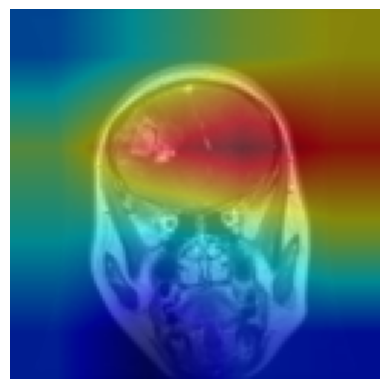

In [13]:
plt.imshow(visualization)
plt.axis('off')
plt.show()

In [15]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

classes = ["glioma", "meningioma", "notumor", "pituitary"]

def visualize_neurons_responsible_for_class(model, samples, specific_category_idx, output_dir):

    gradcam = GradCAM(model=model, target_layers=[model.base_model.features[-1]])

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    count = 0
    for idx, (image, pred, label) in enumerate(samples):
        if label.item() == specific_category_idx:

            input_tensor = image.unsqueeze(0).to(device)
            targets = [ClassifierOutputTarget(pred.item())]

            grayscale_cam = gradcam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            image_np = np.transpose(image.cpu().numpy(), (1, 2, 0))
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

            plt.figure(figsize=(8, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(image_np)
            plt.title(f'Predicted: {classes[pred.item()]}, Actual: {classes[label.item()]}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(image_np)
            plt.imshow(grayscale_cam, cmap='jet', alpha=0.5)
            plt.title('Grad-CAM')
            plt.axis('off')

            # Save the figure to the specified directory
            save_path = os.path.join(output_dir, f'image_{count:03d}.png')
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()

            count += 1

            if count == 50:
                break





In [19]:
specific_category_idx = 3
output_dir = f'outputDenseNet/category_{classes[specific_category_idx]}'
visualize_neurons_responsible_for_class(model, correct_samples, specific_category_idx, output_dir)

In [23]:
specific_category_idx = 3
output_dir = f'outputDenseNetWrongSamples/category_{classes[specific_category_idx]}'
visualize_neurons_responsible_for_class(model, wrong_samples, specific_category_idx, output_dir)

# Using Vision Transformer

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 185.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 131.6 MB/s eta 0:00:00


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from transformers import ViTModel, ViTConfig
from PIL import Image
import os


# Load images and labels
image_paths, labels = load_images_from_folders(folder_paths)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Vision Transformer model
class CustomViT(nn.Module):
    def __init__(self, num_classes):
        super(CustomViT, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.vit.config.hidden_size, momentum=0.99, eps=0.001),
            nn.Linear(self.vit.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.45),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
        
        # Freeze all layers except the last layer for fine-tuning
        for param in self.vit.parameters():
            param.requires_grad = False

        for param in list(self.classifier.parameters()):
            param.requires_grad = True

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        pooled_output = outputs.last_hidden_state[:, 0]
        x = self.classifier(pooled_output)
        return x


# Instantiate the model and move it to the device
model = CustomViT(num_classes=len(folder_paths))
model = model.to(device)

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Encode label
        label = self.label_encoder.transform([label])[0]

        return image, label


# Create datasets and data loaders
dataset = CustomDataset(image_paths, labels, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_predictions / total_predictions
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = loss_func(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_images.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()
            val_total_predictions += val_labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct_predictions / val_total_predictions
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}')


Epoch [1/10], Loss: 0.9475, Accuracy: 0.8247
Validation Loss: 0.8912, Validation Accuracy: 0.8565
Epoch [2/10], Loss: 0.8613, Accuracy: 0.8958
Validation Loss: 0.8884, Validation Accuracy: 0.8653
Epoch [3/10], Loss: 0.8407, Accuracy: 0.9155
Validation Loss: 0.8377, Validation Accuracy: 0.9073
Epoch [4/10], Loss: 0.8245, Accuracy: 0.9313
Validation Loss: 0.8360, Validation Accuracy: 0.9125
Epoch [5/10], Loss: 0.8181, Accuracy: 0.9354
Validation Loss: 0.8283, Validation Accuracy: 0.9186
Epoch [6/10], Loss: 0.8115, Accuracy: 0.9400
Validation Loss: 0.8331, Validation Accuracy: 0.9125
Epoch [7/10], Loss: 0.8095, Accuracy: 0.9396
Validation Loss: 0.8214, Validation Accuracy: 0.9239
Epoch [8/10], Loss: 0.8040, Accuracy: 0.9477
Validation Loss: 0.7950, Validation Accuracy: 0.9519
Epoch [9/10], Loss: 0.8009, Accuracy: 0.9508
Validation Loss: 0.8262, Validation Accuracy: 0.9213
Epoch [10/10], Loss: 0.7943, Accuracy: 0.9547
Validation Loss: 0.8263, Validation Accuracy: 0.9213


# GradCAM on Vision Transformer Predictions

In [51]:
import numpy as np

def reshape_transform(tensor):
    activations = tensor[0]  # Extract the last hidden state
    activations = activations[:, 1:, :]  # Exclude the [CLS] token and get the patch tokens
    activations = activations.permute(0, 2, 1)  # Rearrange to (batch_size, hidden_dim, num_patches)
    activations = activations.view(activations.size(0), activations.size(1), int(activations.size(2) ** 0.5), int(activations.size(2) ** 0.5))
    return activations

input_tensor, target = dataset[0]
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(device)
targets = [ClassifierOutputTarget(target)]
target_layers = [model.vit.encoder.layer[-1]]

with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Get the heatmap for the first image


input_image = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
input_image = input_image - np.min(input_image)
input_image = input_image / np.max(input_image)

# Generate the visualization
visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

AttributeError: 'tuple' object has no attribute 'cpu'

In [ ]:
specific_category_idx = 0
output_dir = f'outputVisionTransformer/category_{classes[specific_category_idx]}'
visualize_neurons_responsible_for_class_transformer(model, reshapes_correct_samples, specific_category_idx, output_dir)